In [5]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('sbux.csv')

## This a snippet of a dataset from kaggle that ranges from February 2013 to February 2018

### Finance Trade Stock Intuition
  - Its a number and each day its a new number
  - It starts early in the morning and closes at the end of the trading day
  - price values are in the tens and volume is in the 100000s
  -

In [6]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [7]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [8]:
# Trying to predict the price itself - Start by doing the wrong thing
series = df['close'].values.reshape(-1, 1)

In [9]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
### Single time series to predict time series
### We built the dataset
# Using T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Data should be N X T X D
Y = np.array(Y)
N = len(X)
print(f'X.Shape {X.shape}, Y.shape {Y.shape}')

X.Shape (1249, 10, 1), Y.shape (1249,)


In [11]:
### Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data = (X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 4s 42ms/step - loss: 0.8502 - val_loss: 5.6044
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.7411 - val_loss: 4.6804
Epoch 3/80
20/20 [==============================] - 0s 10ms/step - loss: 0.6497 - val_loss: 4.0809
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.5754 - val_loss: 3.6328
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.5116 - val_loss: 3.2462
Epoch 6/80
20/20 [==============================] - 0s 9ms/step - loss: 0.4561 - val_loss: 2.9072
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.4066 - val_loss: 2.6200
Epoch 8/80
20/20 [==============================] - 0s 9ms/step - loss: 0.3632 - val_loss: 2.3540
Epoch 9/80
20/20 [==============================] - 0s 9ms/step - loss: 0.3263 - val_loss: 2.1408
Epoch 10/80
20/20 [==============================] - 0s 11ms/step - loss: 0.2955 - val_loss: 1.9622
Epoch 11/80


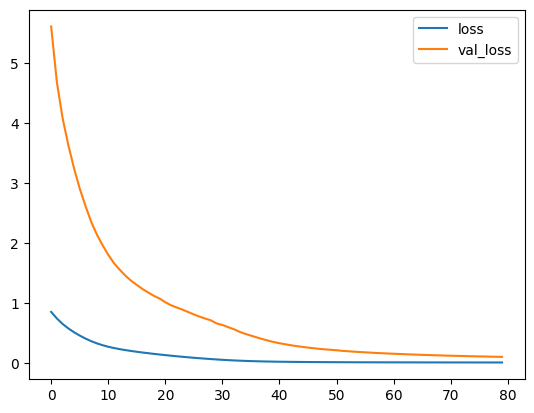

In [12]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 0s 7ms/step
(1249, 1)


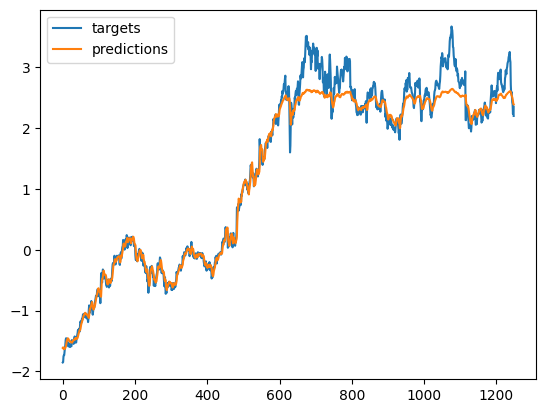

In [15]:
# One step forecasting using the targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()